PIGlets Autoencoder Tutorial
============================

This tutorial is going to go from zero to autoencoders in autograd on the MNIST dataset. In the processing covering all the interesting autoencoder parts:

* Simple Autoencoders
    * Tied weights and Fixed Decoders
    * Undercomplete and Overcomplete
* Feature Learning
* Sparse Autoencoders
* Denoising Autoencoders
* Stacked Architectures
* Deep Autoencoders

This tutorial uses [autograd][], so it might be worth checking the [common autograd pitfalls][pitfalls] before starting.

[autograd]: https://github.com/HIPS/autograd
[pitfalls]: https://github.com/HIPS/autograd/blob/master/docs/tutorial.md#tldr-do-use

In [18]:
import autograd.numpy as np
import autograd.numpy.random as npr
import holoviews as hv
import scipy.ndimage
import scipy.special
from autograd import grad
from tqdm import tqdm
%load_ext holoviews.ipython

The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


Simple Autoencoders
===================

To start with, we just want to train an autoencoder. We're going to use the following architecture:

* Input: $x$ vector 784 pixel values of MNIST digits
* Hidden: $z$ vector 100 units
* Output; $\bar{x}$ reconstructed 784 pixel values of MNIST digits

Of course, to do this we first have to load the MNIST dataset. To do that we're going to use the following handy piece of code from [Lasagne][]:

[lasagne]: https://github.com/Lasagne/Lasagne

In [2]:
# Code copied from: https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py
def load_dataset():
    import os
    from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.
    return X_train.squeeze(), y_train, X_val.squeeze(), y_val, X_test.squeeze(), y_test

In [3]:
Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest = load_dataset()

Unfortunately, autograd isn't optimised in any way like Theano, so in order to get this to run quickly we're going to have to do some aggressive downsizing.

In [4]:
def shrink_images(X, zoom=0.25):
    shrunk_shape = scipy.ndimage.zoom(X[0], zoom).shape
    Xshrunk = np.zeros((X.shape[0], shrunk_shape[0], shrunk_shape[1]))
    for i in tqdm(range(X.shape[0])):
        Xshrunk[i] = scipy.ndimage.zoom(X[i], zoom)
    return Xshrunk

In [5]:
Xtrain = shrink_images(Xtrain)
Xvalid = shrink_images(Xvalid)
Xtest = shrink_images(Xtest)

Now we've loaded MNIST, we might as well take a look at it. The X matrices are are made of rows of pixel values that we can reshape into the 28 by 28 images they represent.

:Layout
   .Image.I    :Image   [x,y]   (z)
   .Image.II   :Image   [x,y]   (z)
   .Image.III  :Image   [x,y]   (z)
   .Image.IV   :Image   [x,y]   (z)
   .Image.V    :Image   [x,y]   (z)
   .Image.VI   :Image   [x,y]   (z)
   .Image.VII  :Image   [x,y]   (z)
   .Image.VIII :Image   [x,y]   (z)
   .Image.IX   :Image   [x,y]   (z)
   .Image.X    :Image   [x,y]   (z)
   .Image.XI   :Image   [x,y]   (z)
   .Image.XII  :Image   [x,y]   (z)
   .Image.XIII :Image   [x,y]   (z)
   .Image.XIV  :Image   [x,y]   (z)
   .Image.XV   :Image   [x,y]   (z)
   .Image.XVI  :Image   [x,y]   (z)
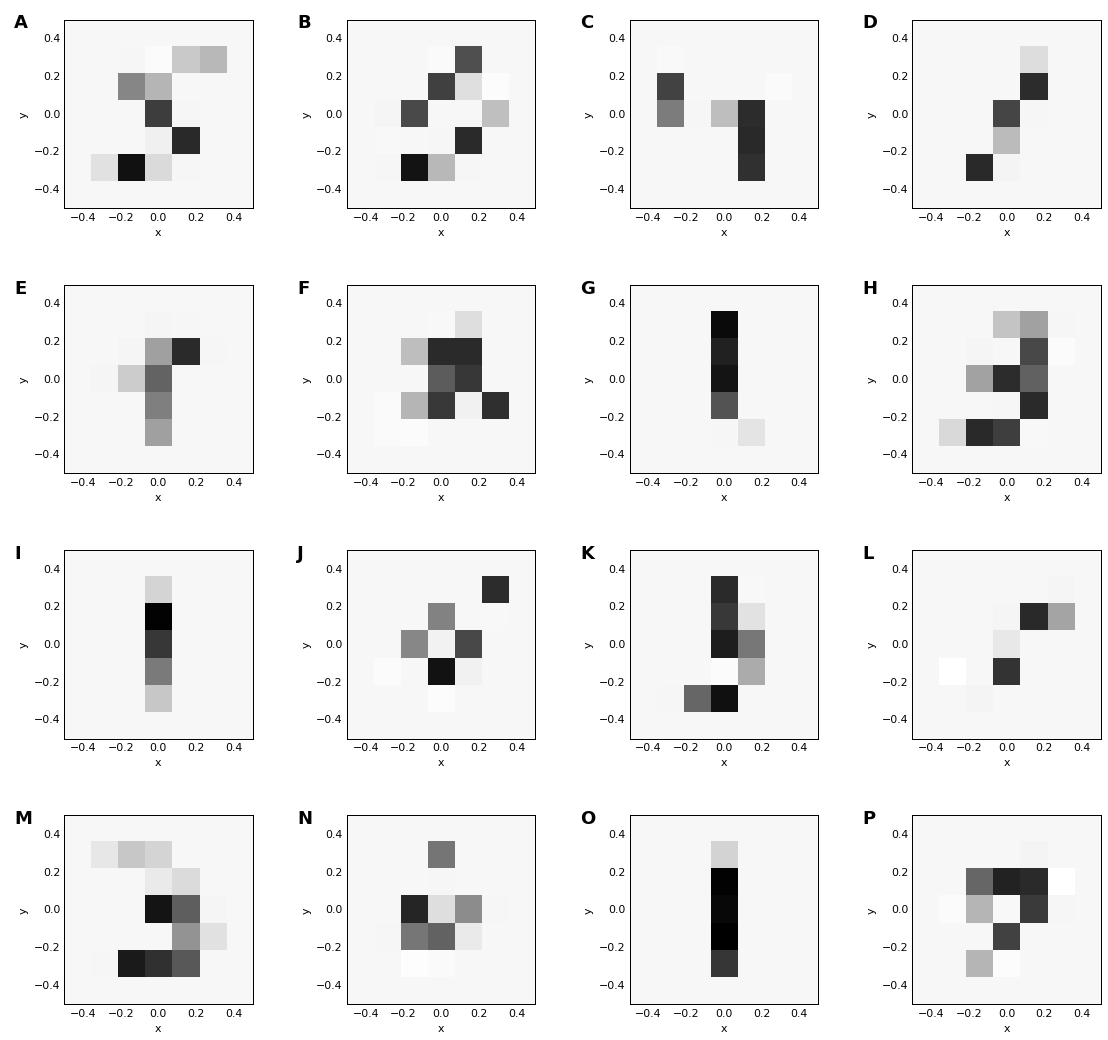

In [6]:
%opts Image (cmap='Greys')
hv.Layout([hv.Image(Xtrain[i,:]) for i in range(16)])

And then, we want these to be vectors:

In [7]:
dim = np.prod(Xtrain.shape[1:])
Xtrain = Xtrain.reshape(-1,dim)
Xvalid = Xvalid.reshape(-1,dim)
Xtest = Xtest.reshape(-1,dim)

For an autoencoder, we're going to need a function to represent a forward pass through our network. The parameters of this model are:

* `encW` - the weights of the encoder
* `encb` - the bias of the encoder
* `decW` - the weights of the decoder
* `decb` - the bias of the decoder

Also, we're going to need a sigmoid nonlinearity, which are favoured in single-layer autoencoders over ReLUs. One reason for this is that the sigmoid is reversible, whereas ReLUs and similar are not. __Why might that important? Is it actually important in practice?__

In [54]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

def forward(encW, encb, decW, decb, X):
    z    = sigmoid(np.dot(X, encW) + encb)
    xbar = sigmoid(np.dot(z, decW) + decb)
    return xbar

Then we're going to need an initialisation, which is going to be standard normal for all weights and zero for all biases.

In [55]:
rng = npr.RandomState(42)
def init_simple(n_hidden, input_dim=Xtrain.shape[1]):
    def sample_layer(inN, outN):
        return rng.randn(inN, outN), np.zeros(outN)
    encW, encb = sample_layer(input_dim, n_hidden)
    decW, decb = sample_layer(n_hidden, input_dim)
    return encW, encb, decW, decb

Now we can initialise a network with 10 hidden units:

In [56]:
params = init_simple(10)

Now we have a forward pass, and parameters with while to perform it. Next we need loss function. The simplest one we can use here is the squared error:

In [57]:
def simple_loss(encW, encb, decW, decb, X):
    network_output = forward(encW, encb, decW, decb, X)
    return np.mean(np.square(X-network_output))

And using the training loss and the magic of automatic differentiation we can immediately get four functions to evaluate the gradient of each of our parameters:

In [58]:
param_grads = [grad(simple_loss, argnum=i) for i in range(4)]

Now, all we need to do is iterate through the dataset in minibatches and use the gradient functions we just created to get the gradients we need to run SGD. Writing a utility function to update all of the parameters.

In [59]:
def update_params(params, param_grads, Xbatch, learning_rate):
    # *params unpacks params into each param_grad function
    grads = [param_grad(*params, Xbatch) for param_grad in param_grads]
    for param, grad in zip(params, grads):
        param += - learning_rate*grad

We run the training loop with a callback function in order to gather results for visualisation. This is defined as an object, and passed into the training function. Both of these are defined below:

In [60]:
class TrackLoss(object):
    def __init__(self):
        self.loss = []
    def __call__(self, loss, i):
        self.loss.append(loss)
    def plot(self):
        return hv.Curve(np.array(self.loss), kdims=['Iteration'], vdims=['Loss'])
# instance callbacks for training and validation losses
tracktrain = TrackLoss()
trackvalid = TrackLoss()

In [61]:
def iterate_minibatches(X, learning_rate=0.01, update_params=None, M=256):
    n_minibatches = X.shape[0]//M
    loss = 0.
    for j in range(n_minibatches):
        # get a minibatch
        Xbatch = X[j*M:(j+1)*M]
        # update parameters with this
        if update_params:
            update_params(params, param_grads, Xbatch, learning_rate)
        # check loss
        loss += (1./n_minibatches)*simple_loss(*params, X)
    return loss

In [62]:
def sgd(params, tracktrain, trackvalid, learning_rate=0.01, n_iter=100):
    for i in tqdm(range(n_iter)):
        # iterate over the training set
        tracktrain(iterate_minibatches(Xtrain, learning_rate, update_params=update_params), i)
        # iterate over validation set
        trackvalid(iterate_minibatches(Xvalid), i)

Unfortunately, single threaded numpy code is (written by me) is _very inefficient_. If we were to do this in [Theano][] instead this would take fraction of the time. Next exercise, use IPython's `%prun` to figure out why my code is so slow; additional exercise: _fix it_.

[theano]: http://deeplearning.net/software/theano/

In [67]:
sgd(params, tracktrain, trackvalid, n_iter=10, learning_rate=0.2)

:Layout
   .Curve.I  :Curve   [Iteration]   (Loss)
   .Curve.II :Curve   [Iteration]   (Loss)
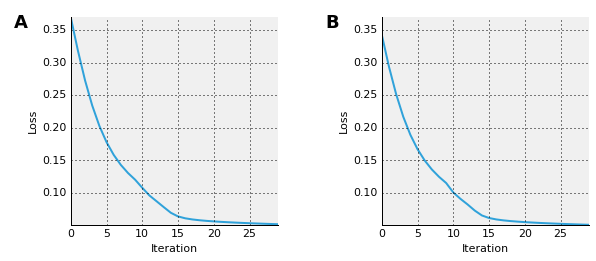

In [68]:
tracktrain.plot()+trackvalid.plot()

Exercises
---------

1. Rewrite the forward propagation to use tied weights, and reduce the number of parameters. Re-train the network and verify that it still works.
2. Instead of using tied weights, try using a random matrix for the decoder. Does this still work? Why? Are there papers about this?
3. That validation loss is dropping to zero?! What the heck?

Feature Learning
================

One application of autoencoders is to learn a representation with which we can get better classification performance. __Compare raw classification performance on a test set against a representation learnt using an undercomplete autoencoder.__

Sparse Autoencoders
===================

By applying a sparsity penalty we can ensure our autoencoder learns a reprensentation that is sparse. __Train with this penalty and verify that we have learnt a sparse representation__.

Denoising Autoencoders
======================

To make the job of the autoencoder a bit more difficult and to make _absolutely sure_ it can't just learn an identity transformation, we can add noise and get the autoencoder to remove it. __Add Gaussian noise to the input and train an autoencoder using this; verify it improves classification performance__.

Stacked Autoencoders
====================

We can learn layered representations layer-wise by stacking denoising autoencoders. __Try to emulate the paper by Hinton on this and see how many stacks you can get to, and how small the final hidden layer can be with reasonable loss__.

Deep Autoencoders
=================

By connecting the stacked layers together we can make a deep autoencoder, and then we can train this entire architecture end-to-end. This rarely works without a good layer-wise initialisation, so is usually called fine-tuning. __Fine tune your stacked architecture, and see how well the whole thing works.__